# Titanic Spacechip - Kaggle Competition

Welcome to the year 2912, where your data science skills are needed to solve a cosmic mystery. We've received a transmission from four lightyears away and things aren't looking good.

The Spaceship Titanic was an interstellar passenger liner launched a month ago. With almost 13,000 passengers on board, the vessel set out on its maiden voyage transporting emigrants from our solar system to three newly habitable exoplanets orbiting nearby stars.

While rounding Alpha Centauri en route to its first destination—the torrid 55 Cancri E—the unwary Spaceship Titanic collided with a spacetime anomaly hidden within a dust cloud. Sadly, it met a similar fate as its namesake from 1000 years before. Though the ship stayed intact, almost half of the passengers were transported to an alternate dimension!

To help rescue crews and retrieve the lost passengers, you are challenged to predict which passengers were transported by the anomaly using records recovered from the spaceship’s damaged computer system.

## Task

In this competition your task is to **predict whether a passenger was transported to an alternate dimension** during the Spaceship Titanic's collision with the spacetime anomaly. To help you make these predictions, you're given a set of personal records recovered from the ship's damaged computer system.


# Dataset

## train.csv
Personal records for about two-thirds (~8700) of the passengers, to be used as training data.

- `PassengerId` - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.

- `HomePlanet` - The planet the passenger departed from, typically their planet of permanent residence.

- `CryoSleep` - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.

- `Cabin` - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.

- `Destination` - The planet the passenger will be debarking to.

- `Age` - The age of the passenger.

- `VIP` - Whether the passenger has paid for special VIP service during the voyage.

- `RoomService`, `FoodCourt`, `ShoppingMall`, `Spa`, `VRDeck` - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.

- `Name` - The first and last names of the passenger.

- `Transported` - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

### test.csv
Personal records for the remaining one-third (~4300) of the passengers, to be used as test data. Your task is to predict the value of Transported for the passengers in this set.

## sample_submission.csv
A submission file in the correct format.
`PassengerId` - Id for each passenger in the test set.



# Initial data exploration

In [36]:
from main import load_train_data, load_test_data

# Load data
titanic_train = load_train_data()

# Explore the dataset
titanic_train.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


There are some missing values. Imputation will be necessary later on.

In [37]:
titanic_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [38]:
titanic = titanic_train.copy()
titanic[["CryoSleep", "VIP", "Transported"]] = titanic[["CryoSleep", "VIP", "Transported"]].convert_dtypes(float)
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   boolean
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   boolean
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   boolean
dtypes: boolean(3), float64(6), object(5)
memory usage: 798.1+ KB


First, we note that there are some values which are objects and bools.

## HomePlanet & Destination

These two features can be one-hot encoded. For HomePlanet we only have three values.

## CryoSleep

Is a boolean value indicating whether the pax was on CryoSleep

## Cabin

Cabin is composed of three datum: Deck/Cabin Number/Side. This feature can be split into three, while Deck and Side can also be one-hot encoded.

## VIP

Boolean feature,

## RoomService, FoodCourt, ShoppingMall, Spa, VRDeck

Indicate the expenses of each passenger. Maybe a feature with the total expenses could be meaningful, but maybe not. Maybe individual expense categories correlate better to the Transported label.

## Name

Maybe uninteresting? won't be used initially

## Transported

Label, indicating whether the pax was transported to another dimension or not.

## HomePlanet & Destination

In [39]:
titanic["HomePlanet"].value_counts()

HomePlanet
Earth     4602
Europa    2131
Mars      1759
Name: count, dtype: int64

In [40]:
titanic["Destination"].value_counts()

Destination
TRAPPIST-1e      5915
55 Cancri e      1800
PSO J318.5-22     796
Name: count, dtype: int64

In [41]:
# Explore the correlation between "Transported" and home planet
earth_survivors = titanic.loc[titanic["HomePlanet"] == "Earth"]["Transported"]
rate_earth_survivors = sum(earth_survivors) / len(earth_survivors)
rate_earth_survivors

0.42394611038678837

In [42]:
# Get the subset of the pax that were transported
transported_pax = titanic[titanic["Transported"]]
transported_rate = len(transported_pax["Transported"]) / len(titanic)
print(f"The rate of transported pax is: {transported_rate}")

The rate of transported pax is: 0.5036236051995858


About half of the pax were transported!

<Axes: xlabel='Home Planet', ylabel='% Transported'>

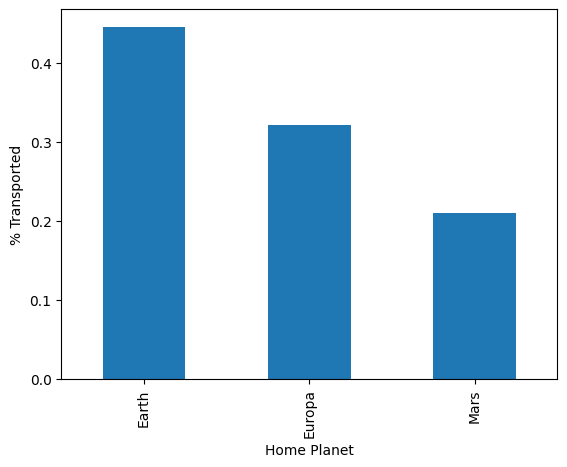

In [43]:
titanic_home_planet_group = titanic.groupby("HomePlanet")
transported_rate = titanic_home_planet_group["Transported"].sum() / len(transported_pax)
transported_rate.plot.bar(x="HomePlanet", y="Transported", xlabel="Home Planet", ylabel="% Transported")

<Axes: xlabel='Destination', ylabel='% Transported'>

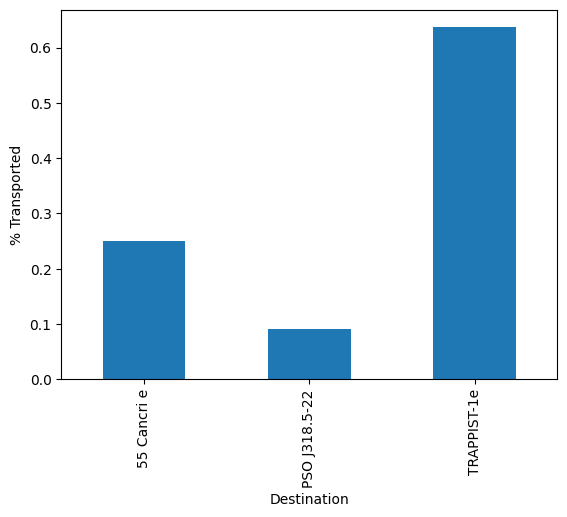

In [44]:
# Explore the rate of transported pax by destination
titanic_destination_group = titanic.groupby(["Destination"])
transported_rate_by_destination = titanic_destination_group["Transported"].sum() / len(transported_pax)
transported_rate_by_destination.plot.bar(x="Destination", y="Transported",
                                         ylabel="% Transported")

It seems that the majority (over 60%) of the transported passengers were travelling to TRAPPIST-1e!

<Axes: xlabel='Cryo Sleep', ylabel='% Transported'>

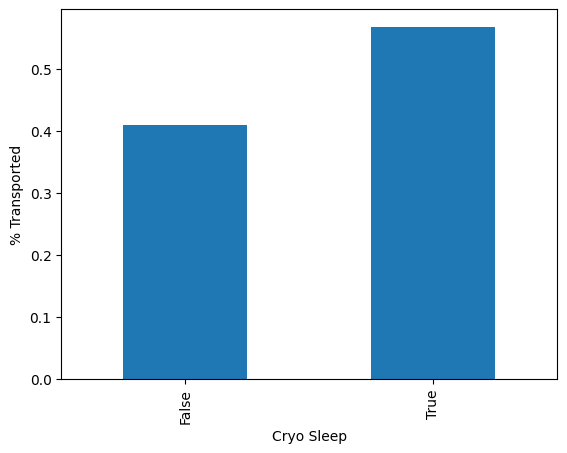

In [45]:
# Explore the Transported rate by CryoSleep
cryo_sleep_group = titanic.groupby("CryoSleep")
transported_rate_by_cryo_sleep = cryo_sleep_group["Transported"].sum() / len(transported_pax)
transported_rate_by_cryo_sleep.plot.bar(x="CryoSleep", y="Transported", xlabel="Cryo Sleep", ylabel="% Transported")

It seems that a majority of transported passengers were in cryogenic sleep.

<Axes: xlabel='VIP Status', ylabel='% Transported'>

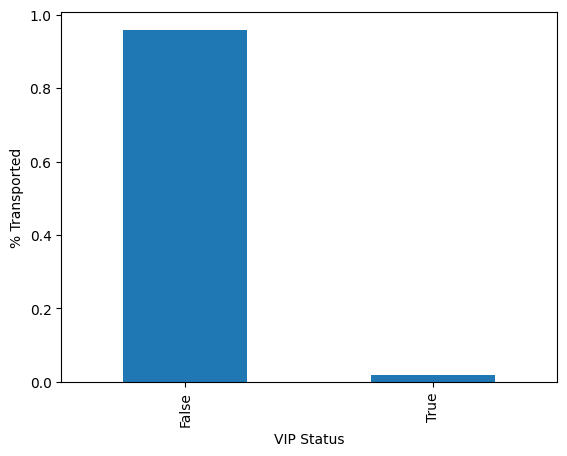

In [46]:
# Explore transported rate by VIP status
vip_group = titanic.groupby("VIP")
vip_transported_rate = vip_group["Transported"].sum() / len(transported_pax)
vip_transported_rate.plot.bar(x="VIP", y="Transported", xlabel="VIP Status", ylabel="% Transported")

In [47]:
transported_vip_pax = titanic[titanic["VIP"]]["Transported"]
transported_vip_rate = len(transported_vip_pax) / len(transported_pax)
print(f"Of {len(transported_pax)} transported passengers only {len(transported_vip_pax)} were VIP")
print(f"Among the transported pax only {transported_vip_rate * 100:.2f}% were VIP")

Of 4378 transported passengers only 199 were VIP
Among the transported pax only 4.55% were VIP


## Boolean features

The boolean features `HomePlanet`, `Destination`, `CryoSleep`, and `VIP` seem to be good indicators of whether a passenger was transported. Include those in the resulting model.


<Axes: >

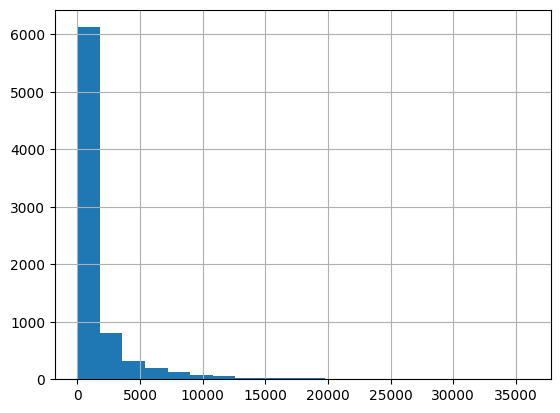

In [48]:
# create a scatter matrix from a few of the potentially relevant numeric features.
# Make the Transformed column a numeric one
titanic["Transported"] = titanic_train["Transported"].astype(int)

# Create a feature for the total expenses
titanic["TotalExpenses"] = titanic["RoomService"] + titanic["FoodCourt"] + titanic[
    "ShoppingMall"] + titanic["Spa"] + titanic["VRDeck"]
titanic["TotalExpenses"].hist(bins=20)

<Axes: xlabel='ExpenseCat', ylabel='Passengers transported'>

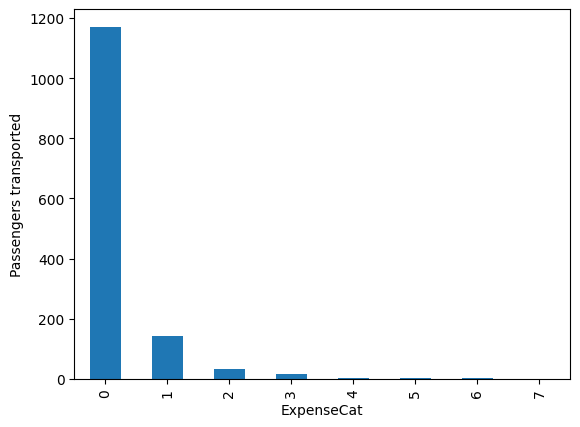

In [49]:
import pandas as pd

# Create expense categories and see how many of each category were transported.
titanic["TotalExpenses"].describe()
bins = range(0, int(titanic["TotalExpenses"].max()) + 5000, 5000)
titanic["ExpenseCat"] = pd.cut(titanic["TotalExpenses"], bins=bins, labels=range(len(bins) - 1))
expense_cat_group = titanic.groupby("ExpenseCat")
expense_cat_group["Transported"].sum().plot.bar(x="ExpenseCat", y="Transported", ylabel="Passengers transported")

The expenses don't seem to have a big effect, since the distribution of transported according to the expense category seems to be very similar as the distribution of expenses among all passengers.

The transported passengers seem to be a sample of the whole ship population in regards to expenses.

<Axes: >

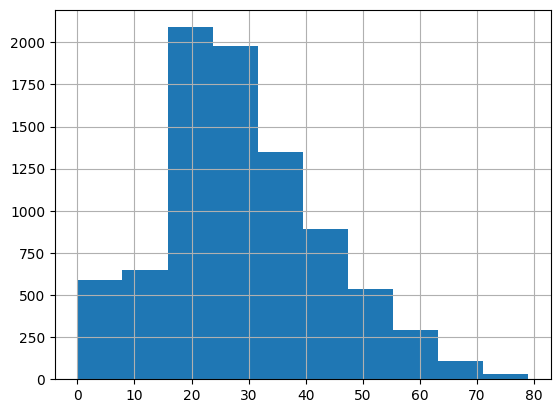

In [50]:
titanic_train["Age"].hist(bins=10)

(array([3.618e+03, 1.920e+02, 5.500e+01, 2.100e+01, 1.400e+01, 6.000e+00,
        2.000e+00, 2.000e+00, 2.000e+00, 0.000e+00]),
 array([    0. ,  3598.7,  7197.4, 10796.1, 14394.8, 17993.5, 21592.2,
        25190.9, 28789.6, 32388.3, 35987. ]),
 <BarContainer object of 10 artists>)

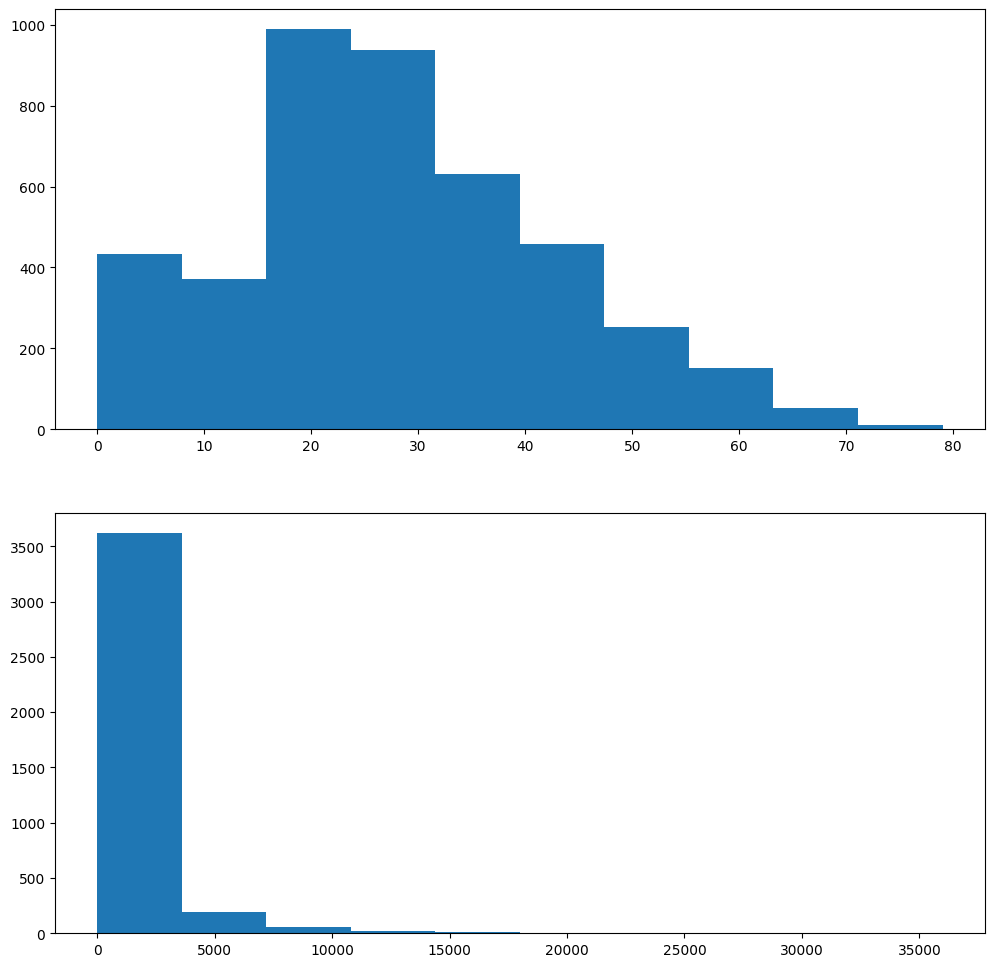

In [51]:
import matplotlib.pyplot as plt

# Plot histogram of number of Transported people according to their Age
plt, ax = plt.subplots(2, 1, figsize=(12, 12))
ax[0].hist(titanic["Age"], weights=titanic["Transported"])
ax[1].hist(titanic["TotalExpenses"], weights=titanic["Transported"])

Apparently, there seems to be no strong correlation between transported passengers and their age or expenses. The transported passengers seem to have been representative of the whole population in this regard.

Inspect other features, such as CryoSleep, VIP, Deck and Side

## Other features

Explore the influence of the feature `Cabin`. The `Cabin` is a string that indicates the deck, cabin number and the side of the ship (P for port and S for starboard).

Separate the cabin number into three separate features: `Deck`, `CabinNumber`, and `Side`.

In [52]:
cabin_data = titanic["Cabin"].str.split("/", expand=True)
titanic[["Deck", "CabinNumber", "Side"]] = cabin_data
titanic.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,TotalExpenses,ExpenseCat,Deck,CabinNumber,Side
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,0,0.0,NaN,B,0,P
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,1,736.0,0,F,0,S
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,0,10383.0,2,A,0,S
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,0,5176.0,1,A,0,S
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,1,1091.0,0,F,1,S


<Axes: xlabel='Deck', ylabel='Passengers transported'>

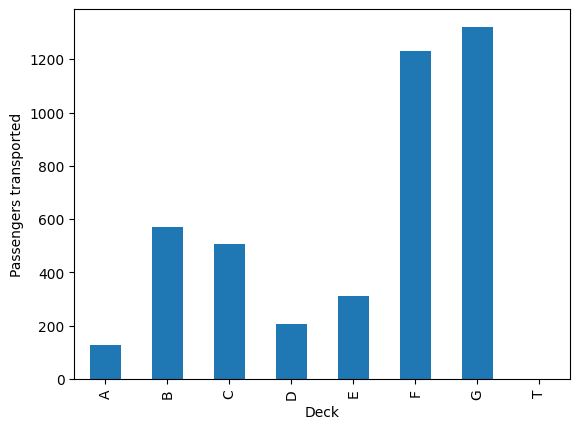

In [53]:
# See how many of each deck were transported.
deck_group = titanic.groupby("Deck")
deck_group["Transported"].sum().plot.bar(x="Deck", y="Transported", ylabel="Passengers transported")

We see that there is a distribution of the transported passengers according to the deck. The distribution has two peaks.

This seems to be a multimodal distribution. For, now, in order to keep it simple, don't do much more about this.

<Axes: xlabel='Side', ylabel='Passengers transported'>

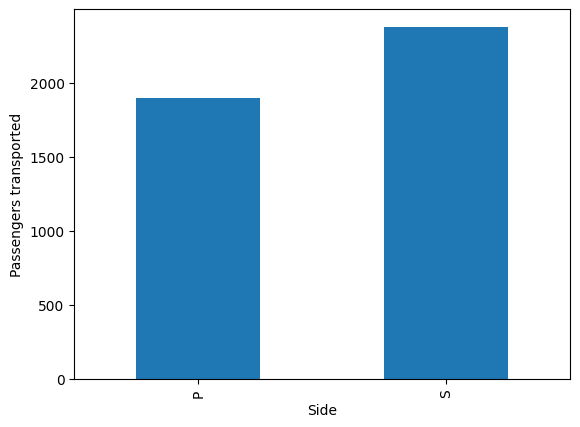

In [54]:
side_group = titanic.groupby("Side")
side_group["Transported"].sum().plot.bar(x="Side", y="Transported", ylabel="Passengers transported")

The side seems to also be a rough indicator for Transported.

# Preparing the data

We've established that some features are better indicators than others. Most features have some correlation with `Transported`, but for instance age, doesn't seem to have a big effect.

In [55]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   PassengerId    8693 non-null   object  
 1   HomePlanet     8492 non-null   object  
 2   CryoSleep      8476 non-null   boolean 
 3   Cabin          8494 non-null   object  
 4   Destination    8511 non-null   object  
 5   Age            8514 non-null   float64 
 6   VIP            8490 non-null   boolean 
 7   RoomService    8512 non-null   float64 
 8   FoodCourt      8510 non-null   float64 
 9   ShoppingMall   8485 non-null   float64 
 10  Spa            8510 non-null   float64 
 11  VRDeck         8505 non-null   float64 
 12  Name           8493 non-null   object  
 13  Transported    8693 non-null   int64   
 14  TotalExpenses  7785 non-null   float64 
 15  ExpenseCat     4538 non-null   category
 16  Deck           8494 non-null   object  
 17  CabinNumber    8494 non-null   ob

In [56]:

from main import split_cabin_feature, calculate_total_expenses, make_expenses_categories
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer

cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore")
)

num_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    StandardScaler()
)

boolean_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent")
)

preprocessing = ColumnTransformer([
    ("cat", cat_pipeline, ["HomePlanet", "Deck", "Side", "Destination"]),
    ("num", num_pipeline, ["Age", "TotalExpenses"]),
    # ("expense_cat", cat_pipeline, ["ExpenseCat"]),
    ("boolean", boolean_pipeline, ["CryoSleep", "VIP"])
])

titanic_train = load_train_data()
y = titanic_train["Transported"]

titanic_train = split_cabin_feature(titanic_train)
titanic_train = calculate_total_expenses(titanic_train)

expense_cat_bins = range(0, 55000, 5000)
expense_cat_labels = range(len(expense_cat_bins) - 1)

titanic_train = make_expenses_categories(titanic_train, bins=expense_cat_bins, labels=expense_cat_labels)

titanic_train = titanic_train.drop("Transported", axis=1)

titanic_prepared = preprocessing.fit_transform(titanic_train)
preprocessing.get_feature_names_out()

array(['cat__HomePlanet_Earth', 'cat__HomePlanet_Europa',
       'cat__HomePlanet_Mars', 'cat__Deck_A', 'cat__Deck_B',
       'cat__Deck_C', 'cat__Deck_D', 'cat__Deck_E', 'cat__Deck_F',
       'cat__Deck_G', 'cat__Deck_T', 'cat__Side_P', 'cat__Side_S',
       'cat__Destination_55 Cancri e', 'cat__Destination_PSO J318.5-22',
       'cat__Destination_TRAPPIST-1e', 'num__Age', 'num__TotalExpenses',
       'boolean__CryoSleep', 'boolean__VIP'], dtype=object)

In [57]:
titanic_prepared.shape

(8693, 20)

In [58]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
model.fit(titanic_prepared, y)

RandomForestClassifier(max_depth=5, random_state=42)

In [59]:
titanic_test = load_test_data()
titanic_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   4277 non-null   object 
 1   HomePlanet    4190 non-null   object 
 2   CryoSleep     4184 non-null   object 
 3   Cabin         4177 non-null   object 
 4   Destination   4185 non-null   object 
 5   Age           4186 non-null   float64
 6   VIP           4184 non-null   object 
 7   RoomService   4195 non-null   float64
 8   FoodCourt     4171 non-null   float64
 9   ShoppingMall  4179 non-null   float64
 10  Spa           4176 non-null   float64
 11  VRDeck        4197 non-null   float64
 12  Name          4183 non-null   object 
dtypes: float64(6), object(7)
memory usage: 434.5+ KB


In [60]:

titanic_test = split_cabin_feature(titanic_test)
titanic_test = calculate_total_expenses(titanic_test)
titanic_test = make_expenses_categories(titanic_test, bins=expense_cat_bins, labels=expense_cat_labels)
titanic_test.shape

(4277, 18)

In [61]:
titanic_test_prepared = preprocessing.fit_transform(titanic_test)
titanic_test_prepared.shape

(4277, 20)

In [66]:
predictions = model.predict(titanic_test_prepared)

KeyError: 'Transported'

In [67]:
output = pd.DataFrame({'PassengerId': titanic_test["PassengerId"], 'Transported': predictions})
output.to_csv('submission.csv', index=False)